# Advanced Graph Build


## Filter Master CSV to First 6 Categories

Process:
1. Load the full `master_clauses.csv`.  
2. Select our six clause-of-interest columns (`Parties`, `Agreement Date`, `Effective Date`, `Expiration Date`, `Renewal Term`, `Notice Period To Terminate Renewal`) plus their corresponding “-Answer” fields.  
3. Filter the DataFrame to retain only contracts with at least one non-empty/positive answer.  
4. Reset the index and save the result to `filtered_master_clauses.csv`.


In [4]:
import pandas as pd

# 1. Load the master CSV
df_master = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\master_clauses.csv')

# 2. Exact column names for our first six categories:
context_cols = [
    "Parties",
    "Agreement Date",
    "Effective Date",
    "Expiration Date",
    "Renewal Term",
    "Notice Period To Terminate Renewal"
]

# Note the precise answer column names (matching the CSV):
answer_cols = [
    "Parties-Answer",
    "Agreement Date-Answer",
    "Effective Date-Answer",
    "Expiration Date-Answer",
    "Renewal Term-Answer",
    "Notice Period To Terminate Renewal- Answer"
]

# 3. Subset to these columns + Filename
cols_to_keep = ["Filename"] + context_cols + answer_cols
df_sub = df_master[cols_to_keep].copy()

# 4. Filter to rows where at least one answer is non-empty/positive
mask = pd.Series(False, index=df_sub.index)
for ans in answer_cols:
    mask |= df_sub[ans].notna() & ~df_sub[ans].isin(["No", "[]", ""])
df_mini = df_sub[mask].reset_index(drop=True)

# 5. Inspect and save
print(f"Filtered to {len(df_mini)} contracts out of {len(df_master)} total.")
print(df_mini.head())

df_mini.to_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv', index=False)
print("Saved filtered CSV to /mnt/data/mini_cuad_master_first6.csv")


Filtered to 509 contracts out of 510 total.
                                            Filename  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3  GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4  IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   

                                             Parties  \
0  ['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...   
1  ['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...   
2  ['Producer', 'Fulucai Productions Ltd.', 'Conv...   
3  ['PSiTech Corporation', 'Licensor', 'Licensee'...   
4  ['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...   

                           Agreement Date  \
0  ['8th day of May 2014', 'May 8, 2014']   
1                      ['July 11 , 2006']   
2                   ['November 15, 2012']   
3                        ['Feb 10, 2014']   
4                   ['December 21, 2015']   

           

## Explode to Clause-Level Snippets

Process:
1. Read `filtered_master_clauses.csv` (contract-level).  
2. Define the six clause context columns.  
3. Iterate over each contract and each context column, extracting non-empty snippets.  
4. Build a snippet-level DataFrame with columns:  
   - `doc_idx` (contract row index)  
   - `filename`  
   - `category`  
   - `snippet_text`  
5. Save the snippet DataFrame to `mini_cuad_snippets.csv`.

Basically for each doc which has a true value for snippet we retrieve the snippet data into a single row.
So if a document has values for multiple clauses , it'll have multiple columns here. These will be the children nodes. While document is the parent node.
Check mini_cuad_snippets.csv

In [5]:
import pandas as pd

# 1. Load the filtered master CSV
df_filtered = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv')

# 2. Define the six clause context columns exactly
context_cols = [
    "Parties",
    "Agreement Date",
    "Effective Date",
    "Expiration Date",
    "Renewal Term",
    "Notice Period To Terminate Renewal"
]

# 3. Explode into one row per non-empty snippet
rows = []
for doc_idx, row in df_filtered.reset_index(drop=True).iterrows():
    for cat in context_cols:
        snippet = row[cat]
        if pd.notna(snippet) and snippet not in ["", "No", "[]"]:
            rows.append({
                "doc_idx": doc_idx,
                "filename": row["Filename"],
                "category": cat,
                "snippet_text": snippet.strip()
            })

snips_df = pd.DataFrame(rows)

# 4. Inspect and save
print(f"Extracted {len(snips_df)} snippets:")
print(snips_df.head())

snips_df.to_csv(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets.csv', index=False)
print("Snippet‐level CSV saved to /mnt/data/mini_cuad_snippets.csv")


Extracted 2069 snippets:
   doc_idx                                           filename  \
0        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
2        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
3        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
4        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   

          category                                       snippet_text  
0          Parties  ['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...  
1   Agreement Date             ['8th day of May 2014', 'May 8, 2014']  
2   Effective Date  ['This agreement shall begin upon the date of ...  
3  Expiration Date  ['This agreement shall begin upon the date of ...  
4     Renewal Term  ['This agreement shall begin upon the date of ...  
Snippet‐level CSV saved to /mnt/data/mini_cuad_snippets.csv


## Embed Clause Snippets


1. Load the snippet‐level CSV (`mini_cuad_snippets.csv`) produced in the previous step.  
2. Initialize a legal‐domain SBERT model (`Stern5497/sbert-legal-xlm-roberta-base`).  [Stil testing with this model]
3. Encode each `snippet_text` into a dense vector, storing the result in a new `embedding` column.  
4. Persist the enriched DataFrame to `mini_cuad_snippets_emb.pkl` for downstream graph construction.


In [ ]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer

# 1. Load snippet table
snips = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets.csv')

# 2. Initialize a legal SBERT model
model = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')

# 3. Embed snippets
snip_texts = snips['snippet_text'].tolist()
snip_embs  = model.encode(snip_texts, show_progress_bar=True)
snips['embedding'] = list(snip_embs)
snips.to_pickle(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets_emb.pkl')
print(f"Encoded {len(snip_embs)} snippets.")



## Test – Verify TXT File Presence

First tried this, 
1. Load `filtered_master_clauses.csv`.  
2. List all expected PDF filenames.  
3. Check for each whether a corresponding `.txt` exists in `full_contract_txt`, and record its file size.  
4. Display a summary table of existence counts and identify any missing or empty files.

Because of slight mismatch of names like `_` instead of `'`

### Test – Fuzzy Match Basenames
1. List all actual `.txt` basenames in the `full_contract_txt` folder.  
2. For each PDF basename with no direct match, use `difflib.get_close_matches` (cutoff=0.8) to propose the closest `.txt` basename.  
3. Display the mapping suggestions to review and ensure slight naming differences (underscores, punctuation) are handled automatically.




In [8]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')

# # 4. Embed full contracts
# master   = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv')
# files    = master['Filename'].unique()
# BASE_TXT_DIR = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'


# doc_texts = []
# for fname in files:
#     # Split off the extension (whether .pdf, .PDF, .Pdf, etc.)
#     base, _ = os.path.splitext(fname)
#     txt_name = base + '.txt'
#     txt_path = os.path.join(BASE_TXT_DIR, txt_name)

#     try:
#         with open(txt_path, encoding='utf-8', errors='ignore') as f:
#             doc_texts.append(f.read())
#     except FileNotFoundError:
#         print(f"⚠️  Missing {txt_path}, adding empty text")
#         doc_texts.append("")


# doc_embs = model.encode(doc_texts, show_progress_bar=True)
# docs_df  = pd.DataFrame({'Filename': files, 'embedding': list(doc_embs)})
# docs_df.to_pickle(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_docs_emb.pkl')
# print(f"Encoded {len(doc_embs)} documents.")

In [ ]:
# import os
# import pandas as pd

# # Adjust to your local paths
# filtered_csv = r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv'
# BASE_TXT_DIR = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'

# master = pd.read_csv(filtered_csv)
# files = master['Filename'].unique().tolist()

# checks = []
# for fname in files:
#     base, _ = os.path.splitext(fname)
#     txt_name = base + '.txt'
#     txt_path = os.path.join(BASE_TXT_DIR, txt_name)
#     exists = os.path.exists(txt_path)
#     size = os.path.getsize(txt_path) if exists else 0
#     checks.append({'Filename': fname, 'TxtName': txt_name, 'Exists': exists, 'SizeBytes': size})

# df_checks = pd.DataFrame(checks)
# print(df_checks.head(20))
# print("\nExistence counts:\n", df_checks['Exists'].value_counts())
# print("\nMissing files:\n", df_checks.loc[~df_checks['Exists'], 'TxtName'].tolist())


                                             Filename  \
0   CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1   EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2   FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3   GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4   IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   
5   DeltathreeInc_19991102_S-1A_EX-10.19_6227850_E...   
6   EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX...   
7   IntegrityMediaInc_20010329_10-K405_EX-10.17_23...   
8   MusclepharmCorp_20170208_10-KA_EX-10.38_989358...   
9   TomOnlineInc_20060501_20-F_EX-4.46_749700_EX-4...   
10  ConformisInc_20191101_10-Q_EX-10.6_11861402_EX...   
11  EtonPharmaceuticalsInc_20191114_10-Q_EX-10.1_1...   
12  FuelcellEnergyInc_20191106_8-K_EX-10.1_1186800...   
13  ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10....   
14  FuseMedicalInc_20190321_10-K_EX-10.43_11575454...   
15  GentechHoldingsInc_20190808_1-A_EX1A-6 MAT CTR...   
16  ImineCorp_20180725_S-1_EX-1

## Final Load & Embed Contracts with Automatic Mapping

1. Build an in-memory mapping from each PDF basename to the best matching TXT basename (exact or fuzzy).  
2. Load each contract’s text via that mapping (falling back to `""` if still unmatched).  
3. Encode all contract texts with the legal SBERT model `Stern5497/sbert-legal-xlm-roberta-base`.  
4. Save the resulting DataFrame of (`Filename`, `embedding`) to `mini_cuad_docs_emb.pkl`.


In [ ]:
import os
import difflib
import pandas as pd
from sentence_transformers import SentenceTransformer

# ── CONFIGURE THESE THREE PATHS ────────────────────────────────
CSV_PATH    = r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv'
TXT_FOLDER  = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'
OUTPUT_PKL  = r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_docs_emb.pkl'
# ────────────────────────────────────────────────────────────────

# 1. Load the list of filenames from your filtered master CSV
df_master = pd.read_csv(CSV_PATH)
pdf_files = df_master['Filename'].unique().tolist()

# 2. List the actual .txt files on disk and strip off their extensions
all_txt = os.listdir(TXT_FOLDER)
txt_basenames = {os.path.splitext(f)[0]: f for f in all_txt}

# 3. Build a mapping PDF-basename → TXT-basename (fuzzy match if needed)
mapping = {}
for pdf in pdf_files:
    base, _ = os.path.splitext(pdf)            
    if base in txt_basenames:
        mapping[base] = base                     # exact match
    else:
        # find the single best match above a 0.8 similarity threshold
        candidates = difflib.get_close_matches(base, txt_basenames.keys(), n=1, cutoff=0.8)
        mapping[base] = candidates[0] if candidates else None

# (Optional) print out any that still didn’t match
unmatched = [b for b,m in mapping.items() if m is None]
if unmatched:
    print(" No .txt match for these basenames:")
    for u in unmatched:
        print("   ", u)

# 4. Load each contract’s text via the mapping
docs_texts = []
for pdf in pdf_files:
    base, _ = os.path.splitext(pdf)
    txt_base = mapping.get(base)
    if txt_base:
        path = os.path.join(TXT_FOLDER, txt_base + '.txt')
        try:
            with open(path, encoding='utf-8', errors='ignore') as f:
                docs_texts.append(f.read())
        except Exception as e:
            print(f"Failed reading {path}: {e}")
            docs_texts.append("")
    else:
        # no good match found
        docs_texts.append("")
        
df_checks = pd.DataFrame(docs_texts)
print(df_checks.head(20))
rows, cols = df_checks.shape
print(f"There are {rows} rows and {cols} columns.")




                                                    0
0   Exhibit 10.27\n\nMARKETING AFFILIATE AGREEMENT...
1   Exhibit 10.B.01 EXECUTION COPY\n\nVIDEO-ON-DEM...
2   CONTENT DISTRIBUTION AND LICENSE AGREEMENT   D...
3   CONFIDENTIAL\n\n  PSiTECHCORPORATION   WEBSITE...
4   CONTENT LICENSE AGREEMENT\n\nTHIS CONTENT LICE...
5   Execution Copy\n\n                       CO-BR...
6   EXHIBIT 10.4\n\n                              ...
7   1                                             ...
8   ENDORSEMENT LICENSING AND CO-BRANDING AGREEMEN...
9   Exhibit 4.46     6 rue Adolphe Fischer L-1520 ...
10  Execution Version Certain identified informati...
11  Exhibit 10.1 Certain information identified by...
12  EXHIBIT 10.1\n\nJOINT DEVELOPMENT AGREEMENT\n\...
13  RECIPE DEVELOPMENT AGREEMENT This Recipe Devel...
14  EXHIBIT 10.43 Dated 29/3/18\n\nDistributorship...
15  Exhibit 6.1 DISTRIBUTOR AGREEMENT THIS DISTRIB...
16  EXHIBIT 10.5 NON-EXCLUSIVE DISTRIBUTOR AGREEME...
17  Exhibit 10.6 ATTACHMENT 

In [ ]:
# 5. Embed with SBERT
model     = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')
doc_embs  = model.encode(docs_texts, show_progress_bar=True)

# 6. Save to disk
output_df = pd.DataFrame({
    'Filename': pdf_files,
    'embedding': list(doc_embs)
})
output_df.to_pickle(OUTPUT_PKL)
print(f"Encoded {len(doc_embs)} documents and saved to {OUTPUT_PKL}")

In [1]:
import os
import shutil

# Define your paths
pdf_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_pdf\test'
txt_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'  # where all .txts currently are
target_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input'  # where you want structured folders

# Create the target root if it doesn't exist
os.makedirs(target_root, exist_ok=True)

# Go through each category
for category in os.listdir(pdf_root):
    category_path = os.path.join(pdf_root, category)
    
    if not os.path.isdir(category_path):
        continue

    # Make output folder for this category
    category_target_folder = os.path.join(target_root, category)
    os.makedirs(category_target_folder, exist_ok=True)

    # Go through each PDF file
    for file in os.listdir(category_path):
        if not file.lower().endswith('.pdf'):
            continue

        base_name = os.path.splitext(file)[0]
        txt_file = base_name + '.txt'
        txt_path = os.path.join(txt_root, txt_file)

        if os.path.exists(txt_path):
            dest_path = os.path.join(category_target_folder, txt_file)
            shutil.copy2(txt_path, dest_path)
        else:
            print(f"❌ Missing text file for {file}")


In [4]:
import os
import re
import pandas as pd
from tqdm import tqdm

def preprocess_legal_text(text):
    """Clean and normalize legal text."""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove line numbers or article numbers like "1.1", "Section 2", etc. (optional)
    text = re.sub(r'\b(Section|Article)?\s?\d+(\.\d+)*[:.)]?\s+', '', text, flags=re.IGNORECASE)
    
    # Normalize special unicode quotes and dashes
    text = text.replace('“', '"').replace('”', '"').replace('–', '-').replace('—', '-')
    
    # Remove page headers/footers if repeating
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    
    return ' '.join(lines).strip()

def load_documents_from_text_folder(base_dir):
    """
    Load and preprocess text files from subfolders in base_dir. 
    Each subfolder is a document category.
    
    Returns a DataFrame with columns: id, name, category, text, file_path
    """
    documents = []
    doc_id = 0

    print(f"Loading documents from: {base_dir}\n")

    for category in sorted(os.listdir(base_dir)):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        category_doc_count = 0
        
        for fname in os.listdir(category_path):
            if not fname.endswith(".txt"):
                continue
            
            file_path = os.path.join(category_path, fname)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    raw_text = f.read()
                    cleaned_text = preprocess_legal_text(raw_text)
                    
                    if len(cleaned_text.split()) < 50:
                        print(f"Skipping too-short file: {fname}")
                        continue
                    
                    documents.append({
                        'id': doc_id,
                        'name': os.path.splitext(fname)[0],
                        'category': category,
                        'text': cleaned_text,
                        'file_path': file_path
                    })
                    doc_id += 1
                    category_doc_count += 1
                    
            except Exception as e:
                print(f" Error reading {file_path}: {e}")
        
        print(f" Loaded {category_doc_count} documents from category: {category}")

    docs_df = pd.DataFrame(documents)
    print(f"\n Total Documents Loaded: {len(docs_df)} across {docs_df['category'].nunique()} categories.")
    return docs_df


In [5]:
base_dir = r"C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input"
docs_df = load_documents_from_text_folder(base_dir)



Loading documents from: C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input

 Loaded 33 documents from category: License_Agreements
 Loaded 34 documents from category: Maintenance
 Loaded 28 documents from category: Service
 Loaded 31 documents from category: Sponsorship
 Loaded 32 documents from category: Strategic Alliance

 Total Documents Loaded: 158 across 5 categories.


In [7]:
print(docs_df.head())  # Shows the first 5 rows


   id                                               name            category  \
0   0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...  License_Agreements   
1   1  ArconicRolledProductsCorp_20191217_10-12B_EX-2...  License_Agreements   
2   2  ArtaraTherapeuticsInc_20200110_8-K_EX-10.5_119...  License_Agreements   
3   3  ChinaRealEstateInformationCorp_20090929_F-1_EX...  License_Agreements   
4   4  CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...  License_Agreements   

                                                text  \
0  ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...   
1  ExhibitFORM OF TRADEMARK LICENSE AGREEMENT THI...   
2  ExhibitCERTAIN CONFIDENTIAL INFORMATION CONTAI...   
3  ExhibitEXECUTION VERSION CONFIDENTIAL DOMAIN N...   
4  ExhibitCertain identified information has been...   

                                           file_path  
0  C:\Repositories\USA_Project\Graph-Test\CUAD_v1...  
1  C:\Repositories\USA_Project\Graph-Test\CUAD_v1...  
2  C:\Repositorie

In [8]:
print(docs_df.info())  # Shows the DataFrame structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         158 non-null    int64 
 1   name       158 non-null    object
 2   category   158 non-null    object
 3   text       158 non-null    object
 4   file_path  158 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.3+ KB
None


In [12]:
import re
import pandas as pd
from tqdm import tqdm

def optimized_hybrid_chunking(docs_df, semantic_min_size=150, semantic_max_size=400,
                             hierarchical_levels=[400, 800], position_importance=True):
    """
    Optimized hybrid chunking combining semantic boundaries with hierarchical representation
    for both search and graph neural network applications.
    """
    chunks = []
    chunk_id_counter = 0 # Use a single counter

    section_patterns = [
        r'(?i)(?:\n|\s{2,})(?:section|article)\s+\d+[\.\:]\s+[A-Z]',
        r'\n[A-Z][A-Z\s]+(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:\d+\.\d+|\d+\.)\s+[A-Z]',
        r'(?i)(?:\n|\s{2,})(?:DEFINITIONS|DEFINED TERMS)(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:WHEREAS:|IN WITNESS WHEREOF:|NOW, THEREFORE,)',
        r'(?i)(?:\n|\s{2,})(?:RECITALS|WITNESSETH|APPENDIX|EXHIBIT|SCHEDULE|ANNEX)\s+[A-Za-z0-9]'
    ]
    compiled_patterns = [re.compile(pattern) for pattern in section_patterns]

    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating hybrid chunks"):
        doc_id_val = doc['id']
        text = doc['text']
        
        # Create word to character offset mapping for the current document
        doc_text_words = text.split() # Based on how preprocess_legal_text works
        char_start_offsets_for_words = [0] * len(doc_text_words)
        current_char_offset = 0
        # This simple split & find might be fragile if text has complex whitespace.
        # preprocess_legal_text aims to normalize this.
        temp_text_for_offsets = text
        for i, word in enumerate(doc_text_words):
            try:
                word_pos = temp_text_for_offsets.find(word)
                char_start_offsets_for_words[i] = current_char_offset + word_pos
                advance_offset = word_pos + len(word)
                current_char_offset += advance_offset
                temp_text_for_offsets = temp_text_for_offsets[advance_offset:]
            except Exception: # Fallback if find fails unexpectedly
                 if i > 0: char_start_offsets_for_words[i] = char_start_offsets_for_words[i-1] + len(doc_text_words[i-1]) + 1
                 else: char_start_offsets_for_words[i] = 0


        doc_chunks_meta_l1 = [] # Store L1 chunk metadata for this doc

        # STEP 1: Create semantic boundaries
        boundaries = [0]
        for pattern in compiled_patterns:
            for match in pattern.finditer(text):
                boundaries.append(match.start())
        paragraph_breaks = [m.start() for m in re.finditer(r'\n\s*\n', text)]
        boundaries.extend(paragraph_breaks)
        boundaries.append(len(text))
        boundaries = sorted(list(set(boundaries)))

        # STEP 2: Create initial semantic_chunks (L1 precursor)
        raw_semantic_chunks = []
        special_sections = {'definitions': None, 'termination': None, 'confidentiality': None, 'indemnification': None}
        
        for i in range(len(boundaries) - 1):
            chunk_text = text[boundaries[i]:boundaries[i+1]].strip()
            if not chunk_text: continue

            lower_text = chunk_text.lower()
            for section_type_key in special_sections:
                if section_type_key in lower_text and len(chunk_text.split()) > 20: # Arbitrary length
                    if special_sections[section_type_key] is None: # Mark first occurrence
                       special_sections[section_type_key] = len(raw_semantic_chunks) 

            total_initial_chunks = len(boundaries) - 1
            position_val = "middle"
            position_score_val = 0.8 if position_importance else 0.7
            if total_initial_chunks > 0 : # Avoid division by zero
                if i < total_initial_chunks * 0.2:
                    position_val = "beginning"; position_score_val = 0.95 if position_importance else 0.7
                elif i > total_initial_chunks * 0.8:
                    position_val = "end"; position_score_val = 0.7 if position_importance else 0.7
            
            raw_semantic_chunks.append({
                'text': chunk_text, 'start_idx': boundaries[i], 'end_idx': boundaries[i+1],
                'position': position_val, 'position_score': position_score_val, 'original_idx': i
            })

        # STEP 3: Process L1 chunk sizes
        processed_l1_chunks = []
        idx_raw_sem = 0
        while idx_raw_sem < len(raw_semantic_chunks):
            chunk = raw_semantic_chunks[idx_raw_sem]
            words = chunk['text'].split()

            if len(words) < semantic_min_size and idx_raw_sem < len(raw_semantic_chunks) - 1:
                next_chunk = raw_semantic_chunks[idx_raw_sem + 1]
                combined_text = chunk['text'] + " " + next_chunk['text'] # Simple space join
                if len(combined_text.split()) <= semantic_max_size:
                    # Merge chunk with next_chunk
                    raw_semantic_chunks[idx_raw_sem + 1]['text'] = combined_text
                    raw_semantic_chunks[idx_raw_sem + 1]['start_idx'] = chunk['start_idx']
                    # Position/score of the merged chunk could be re-evaluated or taken from the first.
                    # For simplicity, next_chunk's original position info is largely kept, but start_idx is updated.
                    idx_raw_sem += 1 # Skip current chunk as it's merged into next
                    continue
            
            if len(words) > semantic_max_size:
                # Try natural sub-divisions first
                sub_texts_natural = re.split(r'\n\s*\n', chunk['text'])
                if len(sub_texts_natural) > 1 and all(len(t.split()) < semantic_max_size for t in sub_texts_natural if t.strip()):
                    current_char_offset_in_chunk = 0
                    for sub_idx, sub_text_natural in enumerate(sub_texts_natural):
                        sub_text_natural = sub_text_natural.strip()
                        if not sub_text_natural: continue
                        
                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if sub_idx > 0 : sub_score = max(0.6, chunk['position_score'] - 0.1 * sub_idx)

                        processed_l1_chunks.append({
                            'text': sub_text_natural,
                            'start_idx': chunk['start_idx'] + current_char_offset_in_chunk,
                            'end_idx': chunk['start_idx'] + current_char_offset_in_chunk + len(sub_text_natural),
                            'position': sub_pos, 'position_score': sub_score, 
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_char_offset_in_chunk += len(sub_text_natural) + (len(chunk['text']) - current_char_offset_in_chunk - len(sub_text_natural) > 0) # Approx for separator
                else: # Forced splits
                    current_word_idx_in_chunk = 0
                    chunk_words = chunk['text'].split() # Words of the current large L1 chunk
                    
                    # Create char offsets for words within this specific chunk['text']
                    # This is relative to the start of chunk['text']
                    offsets_in_chunk_text = [0] * len(chunk_words)
                    temp_chunk_text_ptr = 0
                    search_text_segment = chunk['text']
                    for i_cw, cw in enumerate(chunk_words):
                        try:
                            pos_cw = search_text_segment.find(cw)
                            offsets_in_chunk_text[i_cw] = temp_chunk_text_ptr + pos_cw
                            adv = pos_cw + len(cw)
                            temp_chunk_text_ptr += adv
                            search_text_segment = search_text_segment[adv:]
                        except: # Fallback
                            if i_cw > 0: offsets_in_chunk_text[i_cw] = offsets_in_chunk_text[i_cw-1] + len(chunk_words[i_cw-1]) + 1
                            else: offsets_in_chunk_text[i_cw] = 0


                    while current_word_idx_in_chunk < len(chunk_words):
                        sub_chunk_words = chunk_words[current_word_idx_in_chunk : current_word_idx_in_chunk + semantic_max_size]
                        if not sub_chunk_words: break
                        
                        sub_text_forced = " ".join(sub_chunk_words) # Reconstruct with single spaces

                        # Determine char start/end for this sub_text_forced within original document
                        sub_chunk_char_start_in_chunktext = offsets_in_chunk_text[current_word_idx_in_chunk]
                        
                        # End is start of last word + len of last word
                        idx_of_last_word_in_sub_chunk = current_word_idx_in_chunk + len(sub_chunk_words) - 1
                        sub_chunk_char_end_in_chunktext = offsets_in_chunk_text[idx_of_last_word_in_sub_chunk] + len(chunk_words[idx_of_last_word_in_sub_chunk])


                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if current_word_idx_in_chunk > 0 : sub_score = max(0.6, chunk['position_score'] - 0.1)

                        processed_l1_chunks.append({
                            'text': sub_text_forced,
                            'start_idx': chunk['start_idx'] + sub_chunk_char_start_in_chunktext,
                            'end_idx': chunk['start_idx'] + sub_chunk_char_end_in_chunktext,
                            'position': sub_pos, 'position_score': sub_score,
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_word_idx_in_chunk += len(sub_chunk_words)
            else: # Chunk size is acceptable
                processed_l1_chunks.append(chunk)
            idx_raw_sem += 1
            
        # STEP 4: Create final L1 chunks and then hierarchical chunks (L2+)
        doc_all_level_chunks = []

        # Add L1 (semantic) chunks
        for l1_chunk_data in processed_l1_chunks:
            is_special = False
            special_type_name = None
            parent_orig_idx = l1_chunk_data.get('parent_original_idx', l1_chunk_data.get('original_idx'))

            for sec_type, orig_idx in special_sections.items():
                if orig_idx is not None and parent_orig_idx == orig_idx:
                    is_special = True
                    special_type_name = sec_type
                    break
            
            current_chunk_id = chunk_id_counter
            final_l1_chunk = {
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': l1_chunk_data['text'],
                'chunk_method': 'semantic', 'level': 'L1',
                'start_idx': l1_chunk_data['start_idx'], 'end_idx': l1_chunk_data['end_idx'],
                'document_position': l1_chunk_data['position'], 'position_score': l1_chunk_data['position_score'],
                'is_special_section': is_special
            }
            if is_special: final_l1_chunk['section_type'] = special_type_name
            
            doc_all_level_chunks.append(final_l1_chunk)
            doc_chunks_meta_l1.append({ # For L2+ contained_chunks logic
                'chunk_id': current_chunk_id,
                'char_start_idx': l1_chunk_data['start_idx'], # Char idx
                'char_end_idx': l1_chunk_data['end_idx']      # Char idx
            })
            chunk_id_counter += 1

        # Add L2+ (hierarchical) chunks
        for level_idx, hier_chunk_size_words in enumerate(hierarchical_levels):
            level_name = f"L{level_idx + 2}"
            if len(doc_text_words) < hier_chunk_size_words * 1.5: continue # Skip if doc too short for this level

            overlap_words = min(hier_chunk_size_words // 4, 50)
            
            for i_word_hier in range(0, len(doc_text_words), hier_chunk_size_words - overlap_words):
                hier_sub_words = doc_text_words[i_word_hier : i_word_hier + hier_chunk_size_words]
                if len(hier_sub_words) < hier_chunk_size_words // 3 : continue

                hier_text = " ".join(hier_sub_words)
                
                # Hierarchical chunk boundaries in characters
                hier_char_start = char_start_offsets_for_words[i_word_hier]
                idx_last_word_in_hier = i_word_hier + len(hier_sub_words) -1
                hier_char_end = char_start_offsets_for_words[idx_last_word_in_hier] + len(doc_text_words[idx_last_word_in_hier]) if idx_last_word_in_hier < len(doc_text_words) else len(text)


                pos_hier = "middle"; score_hier = 0.75 if position_importance else 0.7
                total_hier_chunks_at_level = max(1, (len(doc_text_words) - hier_chunk_size_words) // (hier_chunk_size_words - overlap_words) +1)
                current_hier_chunk_index = i_word_hier // (hier_chunk_size_words-overlap_words)
                if total_hier_chunks_at_level > 0:
                    if current_hier_chunk_index < total_hier_chunks_at_level / 3:
                        pos_hier = "beginning"; score_hier = 0.85 if position_importance else 0.7
                    elif current_hier_chunk_index > 2 * total_hier_chunks_at_level / 3:
                        pos_hier = "end"; score_hier = 0.7 if position_importance else 0.7
                
                contained_l1_ids = []
                for l1_meta in doc_chunks_meta_l1:
                    # Check for overlap: max(start1, start2) < min(end1, end2)
                    if max(hier_char_start, l1_meta['char_start_idx']) < min(hier_char_end, l1_meta['char_end_idx']):
                        contained_l1_ids.append(l1_meta['chunk_id'])
                
                current_chunk_id = chunk_id_counter
                doc_all_level_chunks.append({
                    'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                    'category': doc['category'], 'text': hier_text,
                    'chunk_method': 'hierarchical', 'level': level_name, 'level_size': hier_chunk_size_words,
                    'start_idx': hier_char_start, # Store char indices for consistency if preferred
                    'end_idx': hier_char_end,     # Or store word indices i_word_hier, i_word_hier + len(hier_sub_words)
                    'document_position': pos_hier, 'position_score': score_hier,
                    'contained_chunks': contained_l1_ids # List of L1 chunk IDs
                })
                chunk_id_counter += 1
        
        # Full document chunk for small documents
        # Consider adjusting this threshold if you want to change how medium-sized documents are handled
        if len(doc_text_words) < 1000: # Arbitrary threshold, potentially increase if desired
            current_chunk_id = chunk_id_counter
            doc_all_level_chunks.append({
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': text,
                'chunk_method': 'full_document', 'level': 'full',
                'start_idx': 0, 'end_idx': len(text),
                'document_position': 'complete', 'position_score': 1.0,
                'contained_chunks': [m['chunk_id'] for m in doc_chunks_meta_l1]
            })
            chunk_id_counter +=1
            
        chunks.extend(doc_all_level_chunks)

    chunks_df = pd.DataFrame(chunks)
    
    if not chunks_df.empty:
        # Add chunk_relationships
        # This can be slow on very large dataframes.
        # Pre-calculating lookups or using groupby could optimize if needed.
        
        # Create a lookup for L1 chunks per document
        l1_chunks_by_doc = {}
        if 'level' in chunks_df.columns and 'doc_id' in chunks_df.columns and 'chunk_id' in chunks_df.columns:
             l1_chunks_by_doc = chunks_df[chunks_df['level'] == 'L1'].groupby('doc_id')['chunk_id'].apply(list).to_dict()

        # Create a lookup for hierarchical parents
        # A L1 chunk's parents are L2+ chunks that contain it.
        hier_parents_lookup = {} # Key: L1_chunk_id, Value: list of L2+_chunk_ids
        if 'contained_chunks' in chunks_df.columns and 'chunk_method' in chunks_df.columns:
            for _, row in chunks_df.iterrows():
                if row['chunk_method'] == 'hierarchical' or row['chunk_method'] == 'full_document':
                    if isinstance(row['contained_chunks'], list):
                        for l1_child_id in row['contained_chunks']:
                            if l1_child_id not in hier_parents_lookup:
                                hier_parents_lookup[l1_child_id] = []
                            hier_parents_lookup[l1_child_id].append(row['chunk_id'])
        
        def get_relationships(row):
            rels = {'same_doc_l1_chunks': [], 'hierarchical_parents': []}
            if row['level'] == 'L1': # Relationships primarily defined for L1 nodes
                # Same document L1 chunks (excluding self)
                rels['same_doc_l1_chunks'] = [cid for cid in l1_chunks_by_doc.get(row['doc_id'], []) if cid != row['chunk_id']]
                # Hierarchical parents
                rels['hierarchical_parents'] = hier_parents_lookup.get(row['chunk_id'], [])
            return rels
            
        chunks_df['chunk_relationships'] = chunks_df.apply(get_relationships, axis=1)

    print(f"Created {len(chunks_df)} hybrid chunks from {len(docs_df)} documents")
    return chunks_df


Creating hybrid chunks:   0%|          | 0/158 [00:00<?, ?it/s]

Creating hybrid chunks: 100%|██████████| 158/158 [00:14<00:00, 10.90it/s]



Created 6434 hybrid chunks from 158 documents
Selected hybrid chunking with 6434 chunks for further processing.


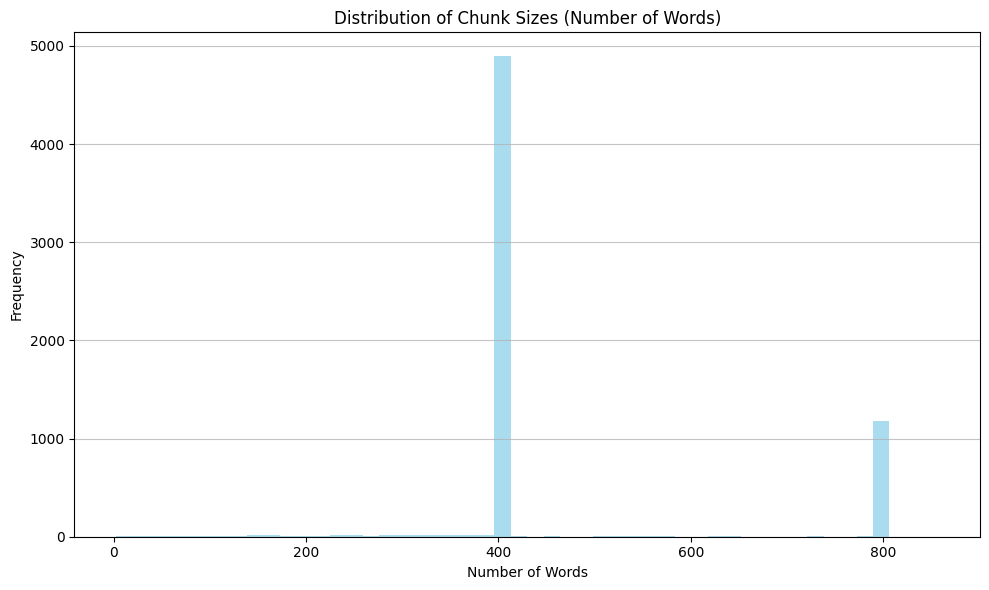

C:\Users\Thevindu Kalubowila\AppData\Local\Temp\ipykernel_15636\3780392110.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


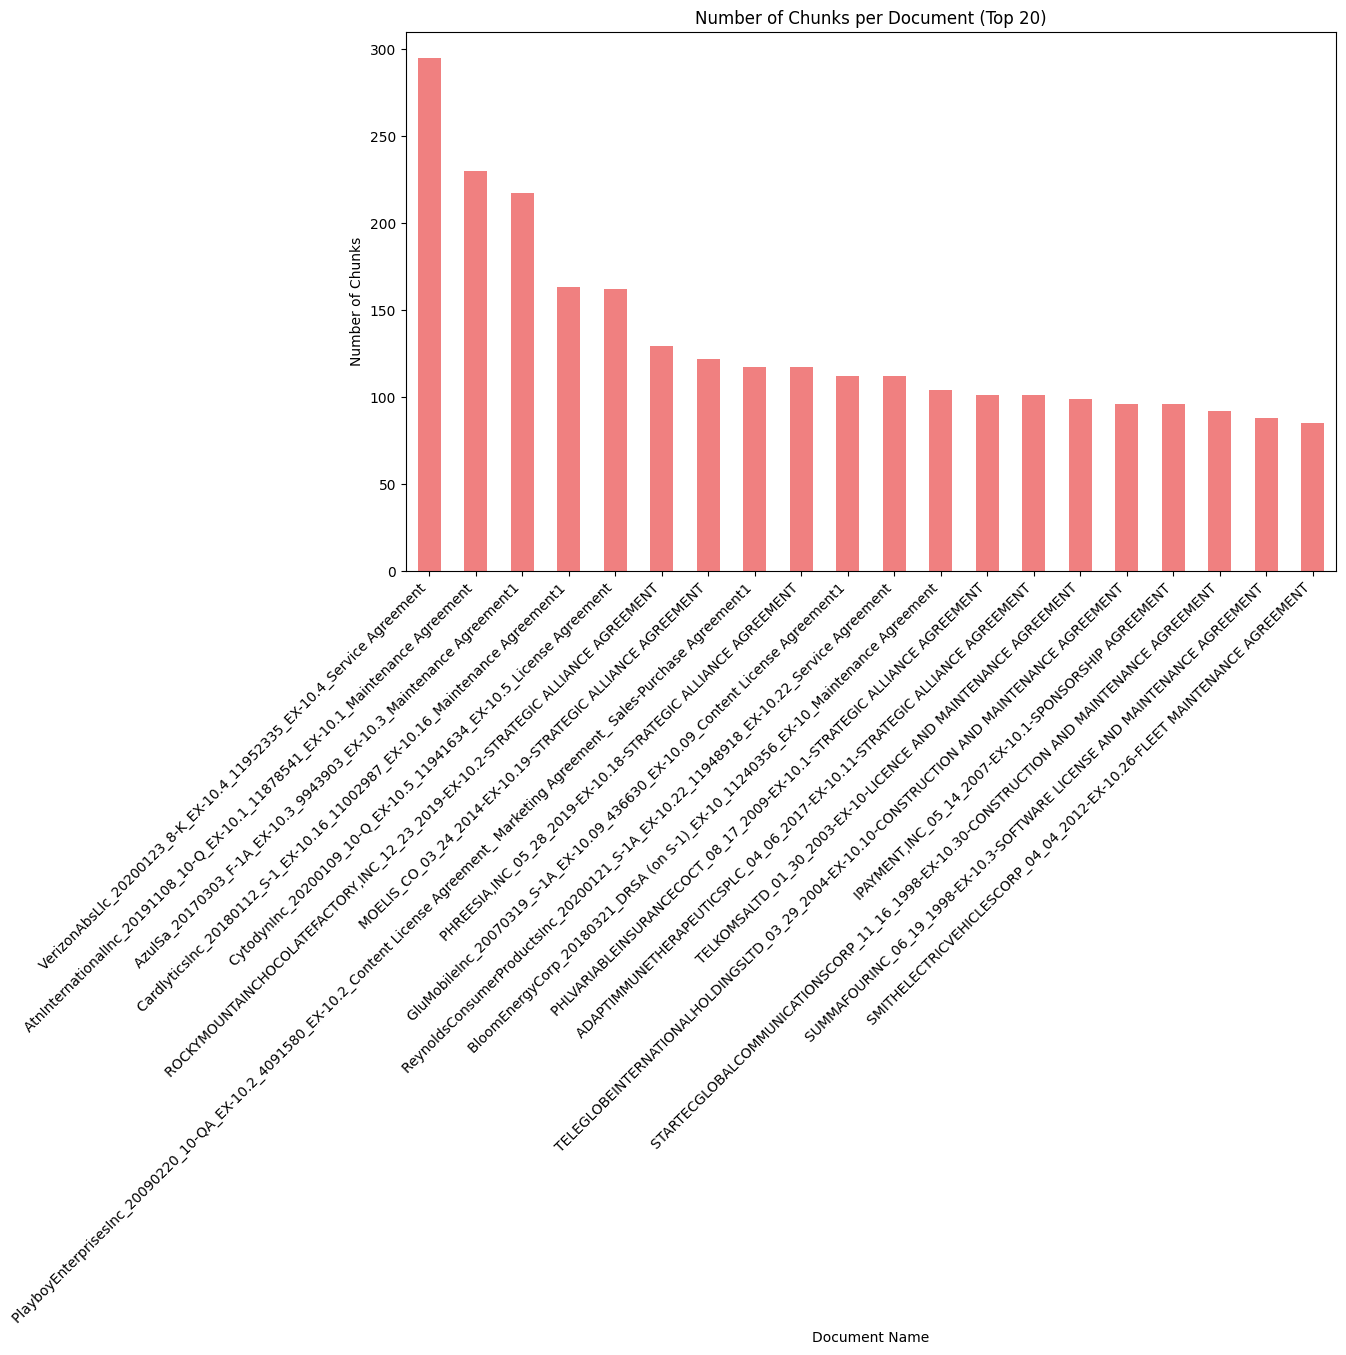

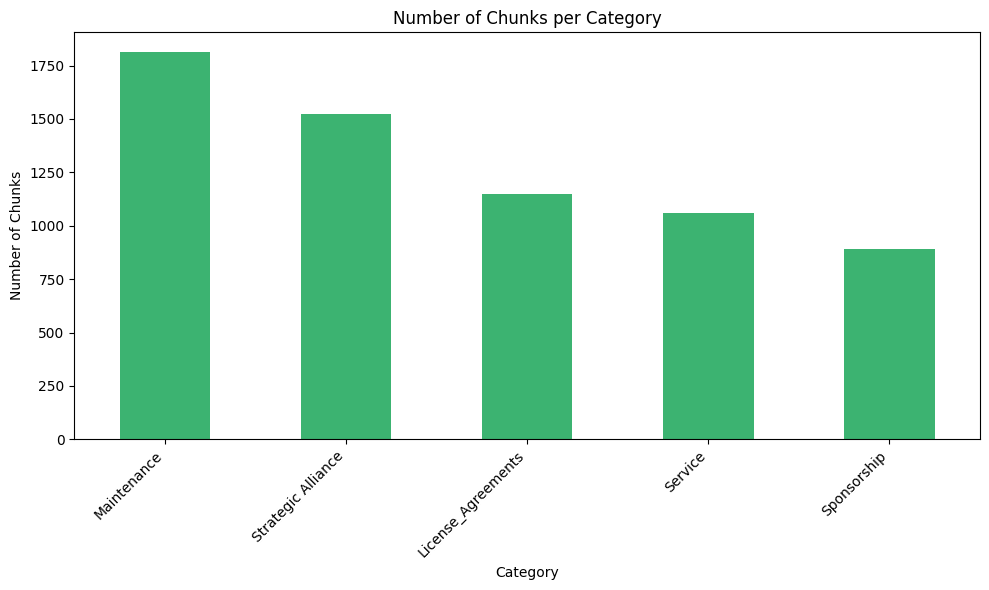

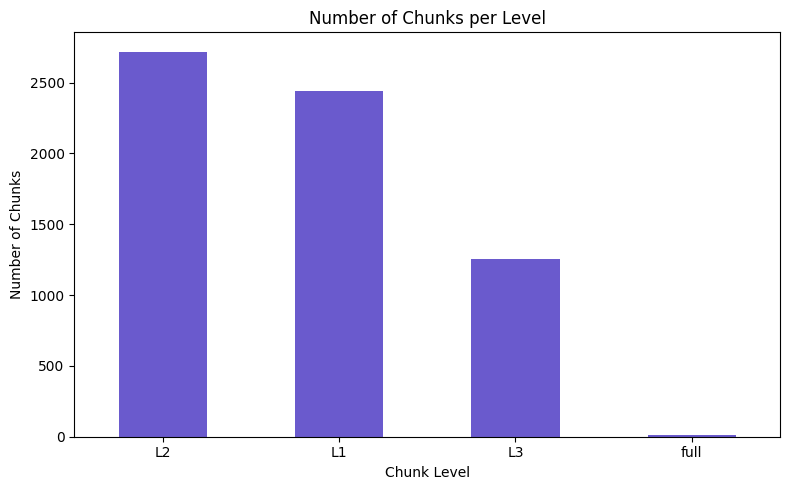

In [13]:
# Assuming docs_df is loaded and preprocessed as in your script
# docs_df = load_documents_from_text_folder("your_base_dir_here")

if docs_df is not None and not docs_df.empty:
    hybrid_chunks_df = optimized_hybrid_chunking(docs_df)
    
    if not hybrid_chunks_df.empty:
        print(f"Selected hybrid chunking with {len(hybrid_chunks_df)} chunks for further processing.")
        
        import matplotlib.pyplot as plt
        import pandas as pd # Ensure pandas is imported if not already
        
        # 1. Chunk Size Distribution
        hybrid_chunks_df['num_words'] = hybrid_chunks_df['text'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(10, 6))
        plt.hist(hybrid_chunks_df['num_words'], bins=50, alpha=0.7, color='skyblue')
        plt.title('Distribution of Chunk Sizes (Number of Words)')
        plt.xlabel('Number of Words')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.tight_layout()
        plt.show()
        
        # 2. Chunks per Document (Sample)
        chunks_per_doc = hybrid_chunks_df.groupby('doc_name').size().sort_values(ascending=False)
        plt.figure(figsize=(12, 7))
        chunks_per_doc.head(20).plot(kind='bar', color='lightcoral') # Display top 20 documents
        plt.title('Number of Chunks per Document (Top 20)')
        plt.xlabel('Document Name')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=45, labelsize=8)
        plt.tight_layout()
        plt.show()
        
        # 3. Chunks per Category
        chunks_per_category = hybrid_chunks_df.groupby('category').size().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        chunks_per_category.plot(kind='bar', color='mediumseagreen')
        plt.title('Number of Chunks per Category')
        plt.xlabel('Category')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=45, labelsize=8)
        plt.tight_layout()
        plt.show()
        
        # 4. Chunks per Level
        chunks_per_level = hybrid_chunks_df.groupby('level').size().sort_values(ascending=False)
        plt.figure(figsize=(8, 5))
        chunks_per_level.plot(kind='bar', color='slateblue')
        plt.title('Number of Chunks per Level')
        plt.xlabel('Chunk Level')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No hybrid chunks available for processing.")
else:
    print("docs_df is empty. Please check the document loading and preprocessing steps.")

In [14]:
# Analysis of Large Chunks

# Assuming hybrid_chunks_df is available and has the 'num_words' column from previous plotting
if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty and 'num_words' in hybrid_chunks_df.columns:
    large_chunk_threshold = 500
    large_chunks_df = hybrid_chunks_df[hybrid_chunks_df['num_words'] > large_chunk_threshold]

    print(f"Analysis of Chunks with more than {large_chunk_threshold} words:\n")
    
    if not large_chunks_df.empty:
        num_large_chunks = len(large_chunks_df)
        total_chunks = len(hybrid_chunks_df)
        percentage_large_chunks = (num_large_chunks / total_chunks) * 100
        
        print(f"Number of large chunks (> {large_chunk_threshold} words): {num_large_chunks}")
        print(f"Percentage of total chunks: {percentage_large_chunks:.2f}%")
        
        print("\nDescriptive statistics for word counts of large chunks:")
        print(large_chunks_df['num_words'].describe())
        
        print("\nSample of large chunks (showing doc_name, level, num_words, and start of text):")
        # Display relevant columns and a snippet of the text
        # Adding .copy() to avoid SettingWithCopyWarning if we were to modify sample_display
        sample_display = large_chunks_df[['doc_name', 'level', 'chunk_method', 'num_words', 'text']].copy()
        sample_display['text_preview'] = sample_display['text'].apply(lambda x: x[:200] + '...' if len(x) > 200 else x)
        
        # Check if 'display' is available (i.e., in a Jupyter environment)
        try:
            display(sample_display[['doc_name', 'level', 'chunk_method', 'num_words', 'text_preview']].head(10))
        except NameError:
            print(sample_display[['doc_name', 'level', 'chunk_method', 'num_words', 'text_preview']].head(10).to_string())
            
        # You might also want to see which documents contribute most to these large chunks
        print("\nDocuments with the most large chunks:")
        doc_counts_large_chunks = large_chunks_df['doc_name'].value_counts()
        try:
            display(doc_counts_large_chunks.head())
        except NameError:
            print(doc_counts_large_chunks.head().to_string())
            
        print("\nChunk levels of these large chunks:")
        level_counts_large_chunks = large_chunks_df['level'].value_counts()
        try:
            display(level_counts_large_chunks.head())
        except NameError:
            print(level_counts_large_chunks.head().to_string())
    else:
        print(f"No chunks found with more than {large_chunk_threshold} words.")
else:
    print("'hybrid_chunks_df' with 'num_words' column not found. Please run the previous cells to generate it.")

Analysis of Chunks with more than 500 words:

Number of large chunks (> 500 words): 1231
Percentage of total chunks: 19.13%

Descriptive statistics for word counts of large chunks:
count    1231.000000
mean      792.872461
std        38.335670
min       501.000000
25%       800.000000
50%       800.000000
75%       800.000000
max       858.000000
Name: num_words, dtype: float64

Sample of large chunks (showing doc_name, level, num_words, and start of text):


,doc_name,level,chunk_method,num_words,text_preview
29,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...
30,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,"and WPT Enterprises, Inc. (""WPT""). DEFINITIONS..."
31,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,"Licensor's marks (including, without limitatio..."
32,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,"from such Royalties as are, or have become, pa..."
33,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,or any related amendment signed by the Parties...
34,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,"have, whether pursuant to the provisions of th..."
35,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,L3,hierarchical,800,of which shall be an original and all of which...
51,ArconicRolledProductsCorp_20191217_10-12B_EX-2...,L3,hierarchical,800,ExhibitFORM OF TRADEMARK LICENSE AGREEMENT THI...
52,ArconicRolledProductsCorp_20191217_10-12B_EX-2...,L3,hierarchical,800,"calendar year, Licensee shall submit samples t..."
53,ArconicRolledProductsCorp_20191217_10-12B_EX-2...,L3,hierarchical,800,import; or (b) the filing of an involuntary pe...



Documents with the most large chunks:


doc_name
VerizonAbsLlc_20200123_8-K_EX-10.4_11952335_EX-10.4_Service Agreement               58
AtnInternationalInc_20191108_10-Q_EX-10.1_11878541_EX-10.1_Maintenance Agreement    45
AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1                 43
CardlyticsInc_20180112_S-1_EX-10.16_11002987_EX-10.16_Maintenance Agreement1        32
CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-10.5_License Agreement                 32
Name: count, dtype: int64


Chunk levels of these large chunks:


level
L3      1222
full       9
Name: count, dtype: int64

In [15]:
# Analysis of Documents with High Chunk Counts
if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty:
    # Calculate the number of chunks per document
    chunks_per_document = hybrid_chunks_df.groupby('doc_id').size().reset_index(name='num_chunks')
    # Merge with doc_name for readability (assuming doc_id to doc_name is unique or take first)
    doc_names_df = hybrid_chunks_df[['doc_id', 'doc_name']].drop_duplicates(subset=['doc_id'])
    chunks_per_document = pd.merge(chunks_per_document, doc_names_df, on='doc_id', how='left')
    
    chunks_per_document = chunks_per_document.sort_values(by='num_chunks', ascending=False)
    
    print("Top 20 documents by number of chunks:\n")
    try:
        display(chunks_per_document.head(20))
    except NameError:
        print(chunks_per_document.head(20).to_string())
    
    high_chunk_threshold = 700 # You can adjust this threshold
    documents_with_many_chunks = chunks_per_document[chunks_per_document['num_chunks'] >= high_chunk_threshold]
    
    if not documents_with_many_chunks.empty:
        print(f"\n--- Detailed Analysis for Documents with >= {high_chunk_threshold} Chunks ---")
        for _, row in documents_with_many_chunks.iterrows():
            doc_id_val = row['doc_id']
            doc_name_val = row['doc_name']
            num_chunks_val = row['num_chunks']
            
            print(f"\nDocument: {doc_name_val} (ID: {doc_id_val}) - Total Chunks: {num_chunks_val}")
            
            doc_specific_chunks = hybrid_chunks_df[hybrid_chunks_df['doc_id'] == doc_id_val]
            level_distribution = doc_specific_chunks['level'].value_counts()
            method_distribution = doc_specific_chunks['chunk_method'].value_counts()
            
            print("Chunk Level Distribution:")
            try:
                display(level_distribution)
            except NameError:
                print(level_distribution.to_string())
                
            print("Chunk Method Distribution:")
            try:
                display(method_distribution)
            except NameError:
                print(method_distribution.to_string())
            
            # You could also print average words per chunk for these specific documents
            # avg_words = doc_specific_chunks['text'].apply(lambda x: len(x.split())).mean()
            # print(f"Average words per chunk for this document: {avg_words:.2f}")
            
    else:
        print(f"\nNo documents found with {high_chunk_threshold} or more chunks.")
else:
    print("'hybrid_chunks_df' not found or is empty. Please run the chunking steps first.")

Top 20 documents by number of chunks:



,doc_id,num_chunks,doc_name
93,93,295,VerizonAbsLlc_20200123_8-K_EX-10.4_11952335_EX...
33,33,230,AtnInternationalInc_20191108_10-Q_EX-10.1_1187...
34,34,217,AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_M...
37,37,163,CardlyticsInc_20180112_S-1_EX-10.16_11002987_E...
4,4,162,CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...
150,150,129,"ROCKYMOUNTAINCHOCOLATEFACTORY,INC_12_23_2019-E..."
144,144,122,MOELIS_CO_03_24_2014-EX-10.19-STRATEGIC ALLIAN...
147,147,117,"PHREESIA,INC_05_28_2019-EX-10.18-STRATEGIC ALL..."
26,26,117,PlayboyEnterprisesInc_20090220_10-QA_EX-10.2_4...
86,86,112,ReynoldsConsumerProductsInc_20200121_S-1A_EX-1...



No documents found with 700 or more chunks.


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


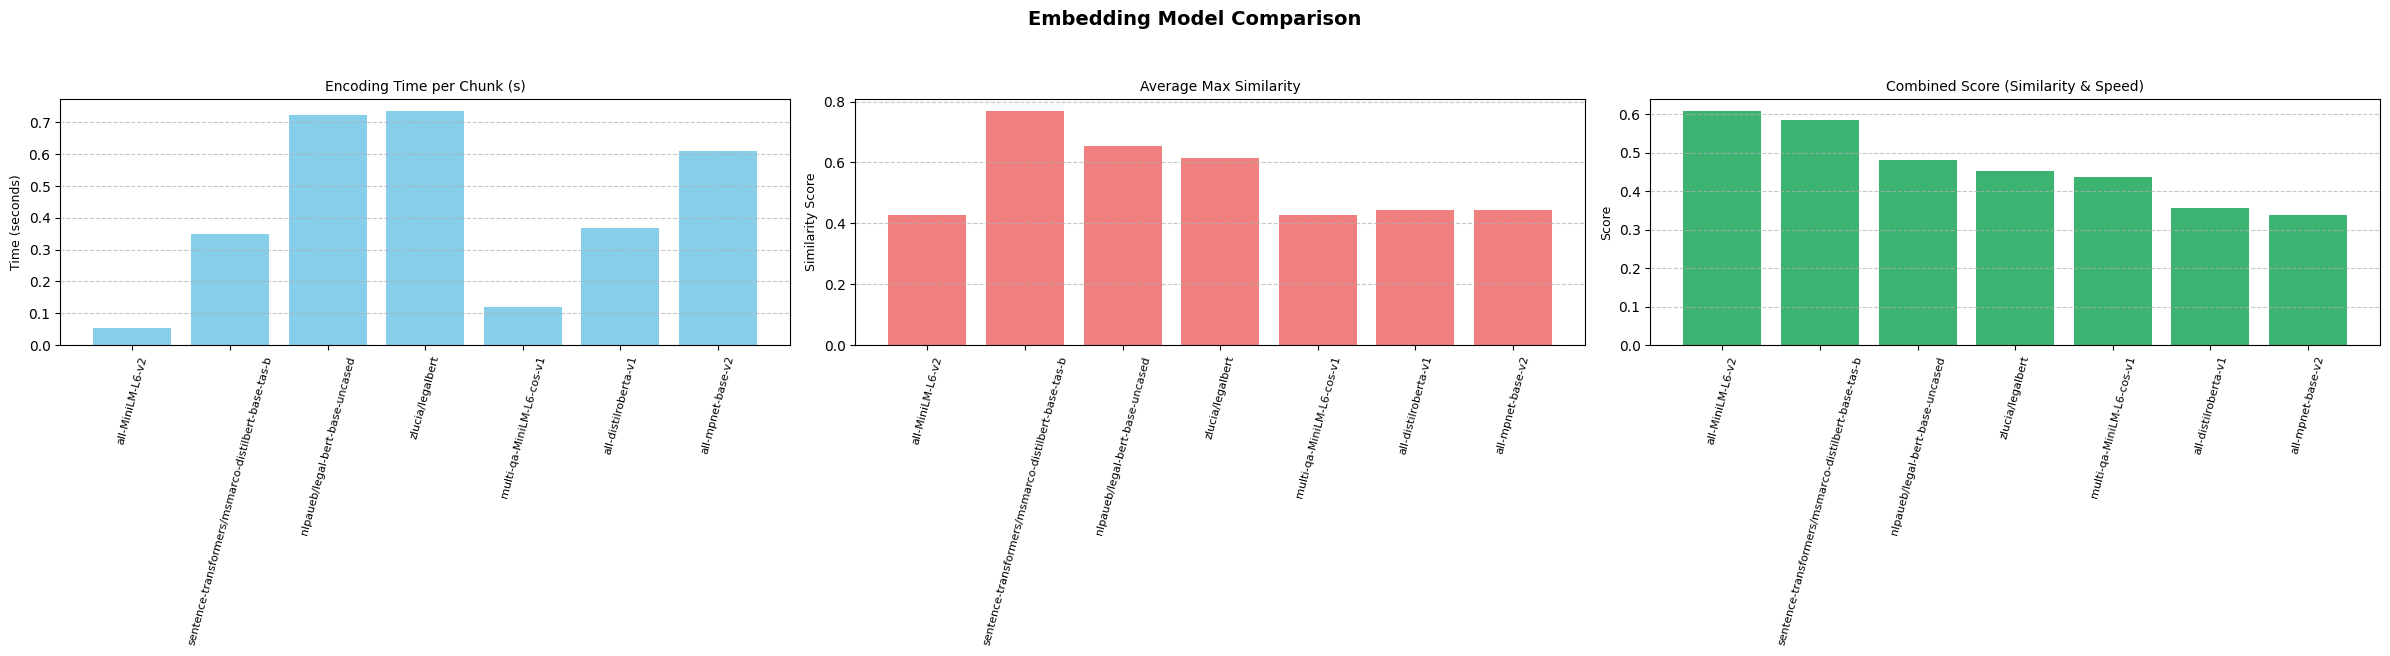

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


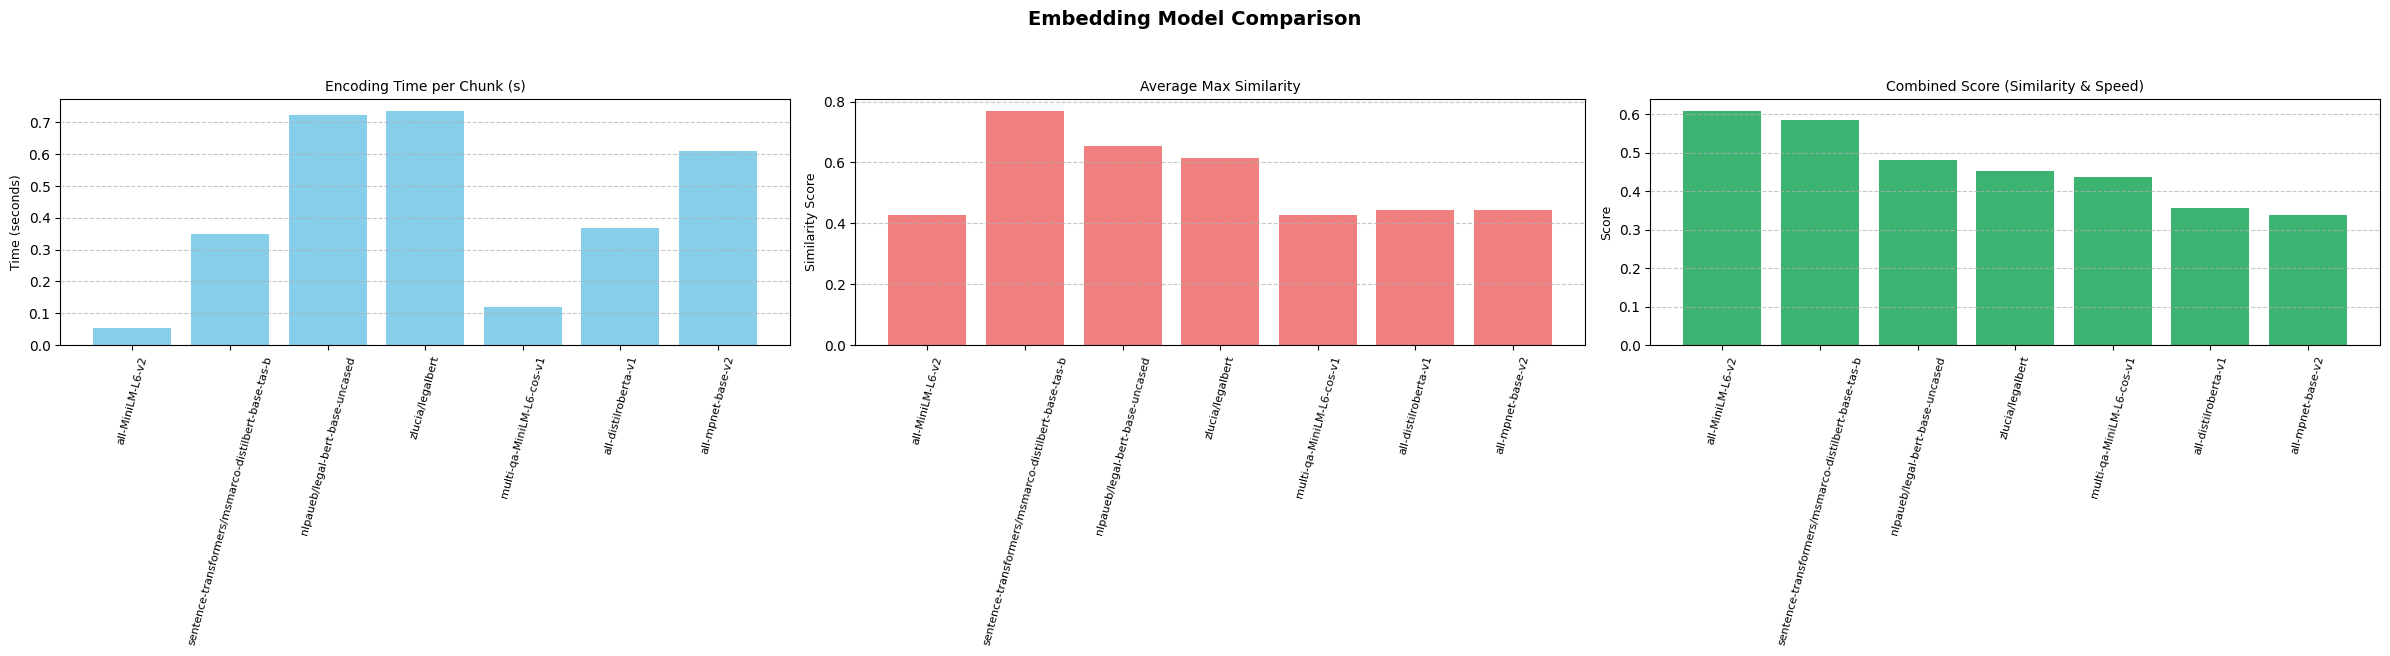


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


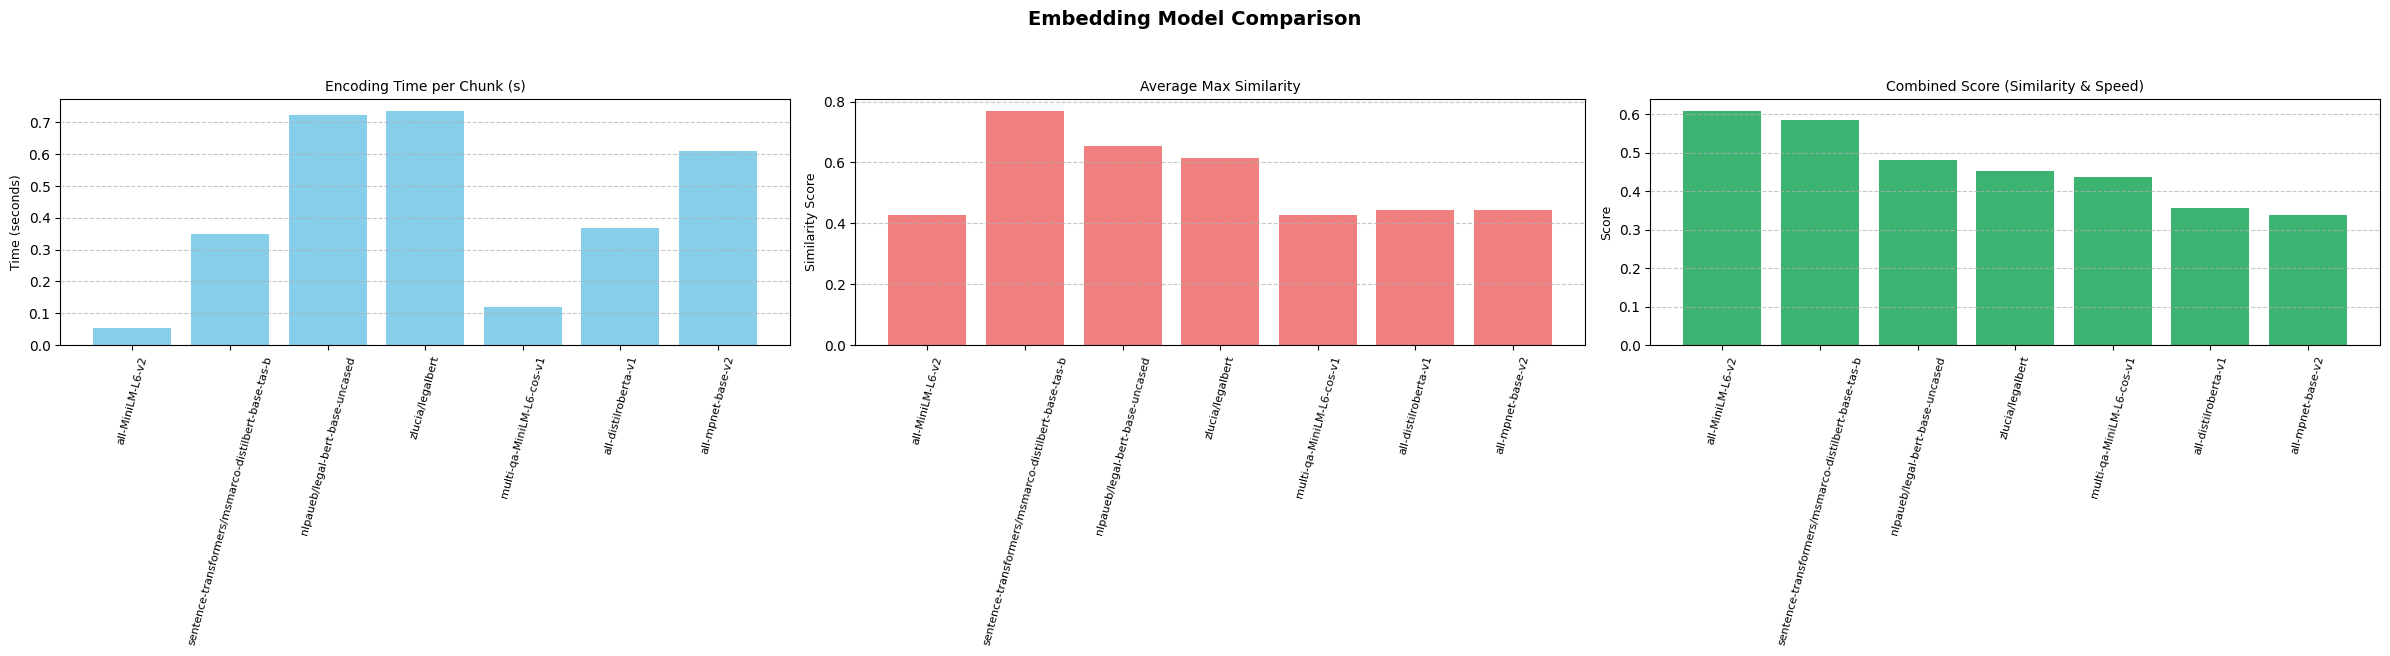


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


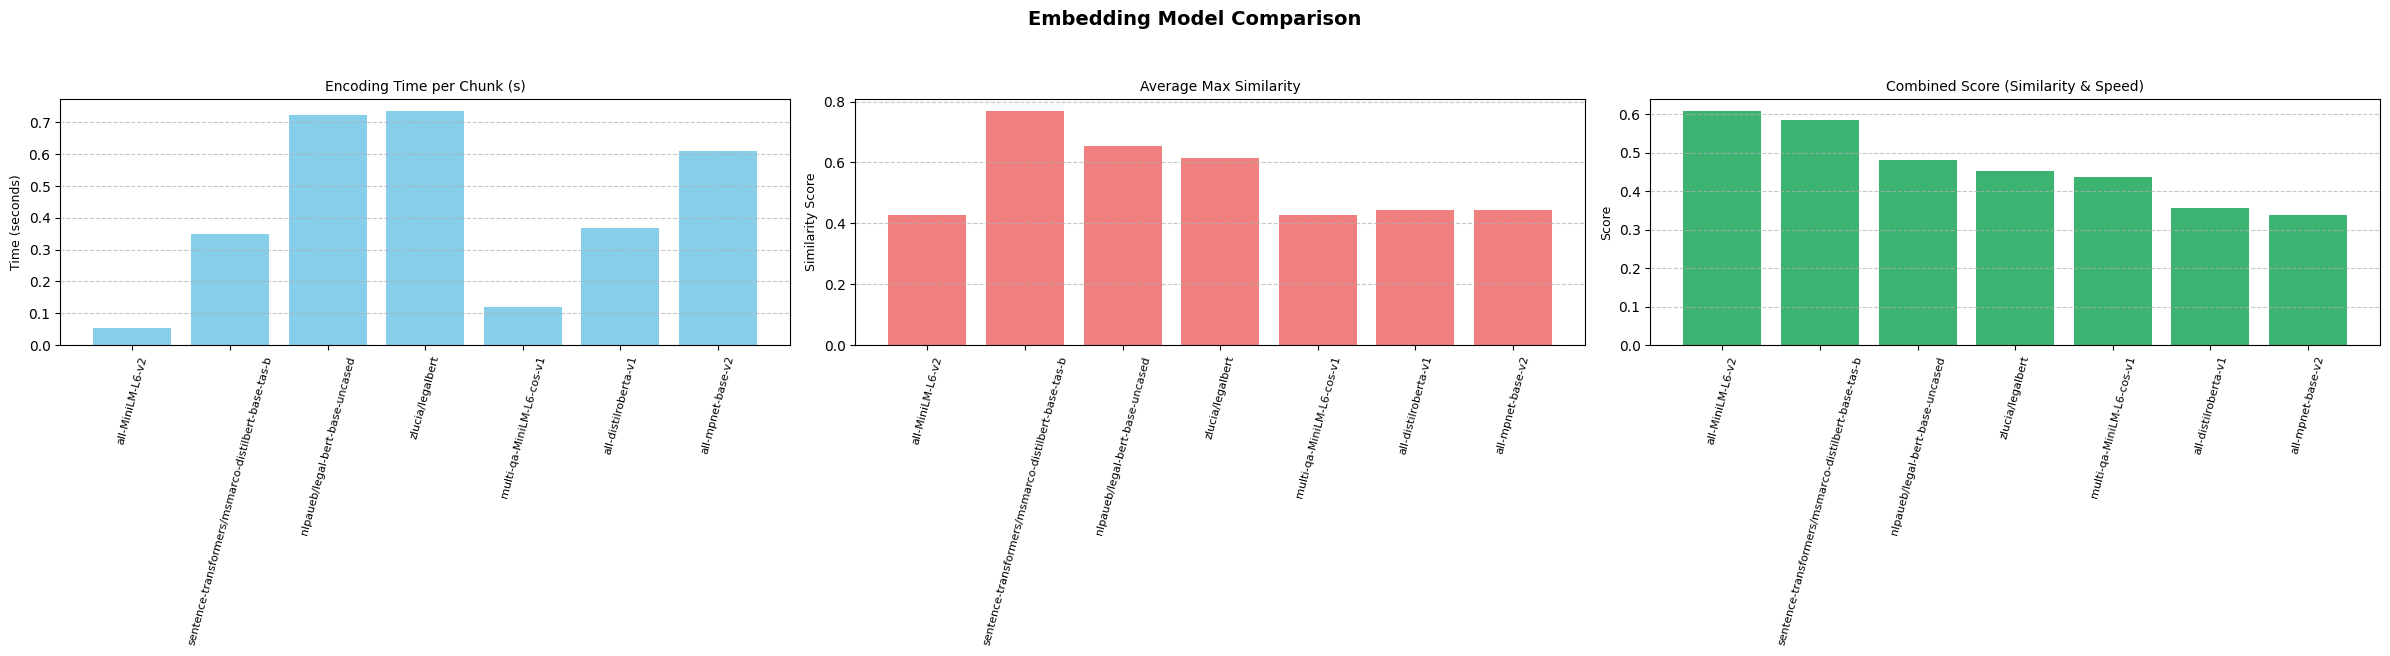


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Generated embeddings with shape: (6434, 384)

Finished generating embeddings. Shape of matrix: (6434, 384)
`hybrid_chunks_df` DataFrame now contains the 'embedding' column.
`full_embeddings_matrix` holds the numpy array of embeddings.
`final_model_object` is the loaded SentenceTransformer model.


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,4.603690,5.444025,0.428944,0.054440,0.608531
2,sentence-transformers/msmarco-distilbert-base-...,768,5.046333,34.825603,0.768942,0.348256,0.586449
3,nlpaueb/legal-bert-base-uncased,768,3.171870,72.356311,0.653772,0.723563,0.480835
4,zlucia/legalbert,768,4.602424,73.570784,0.615028,0.735708,0.453331
1,multi-qa-MiniLM-L6-cos-v1,384,4.085175,12.046566,0.427118,0.120466,0.438295
6,all-distilroberta-v1,768,4.509183,36.695670,0.442404,0.366957,0.355417
5,all-mpnet-base-v2,768,4.039202,60.947440,0.444712,0.609474,0.338834


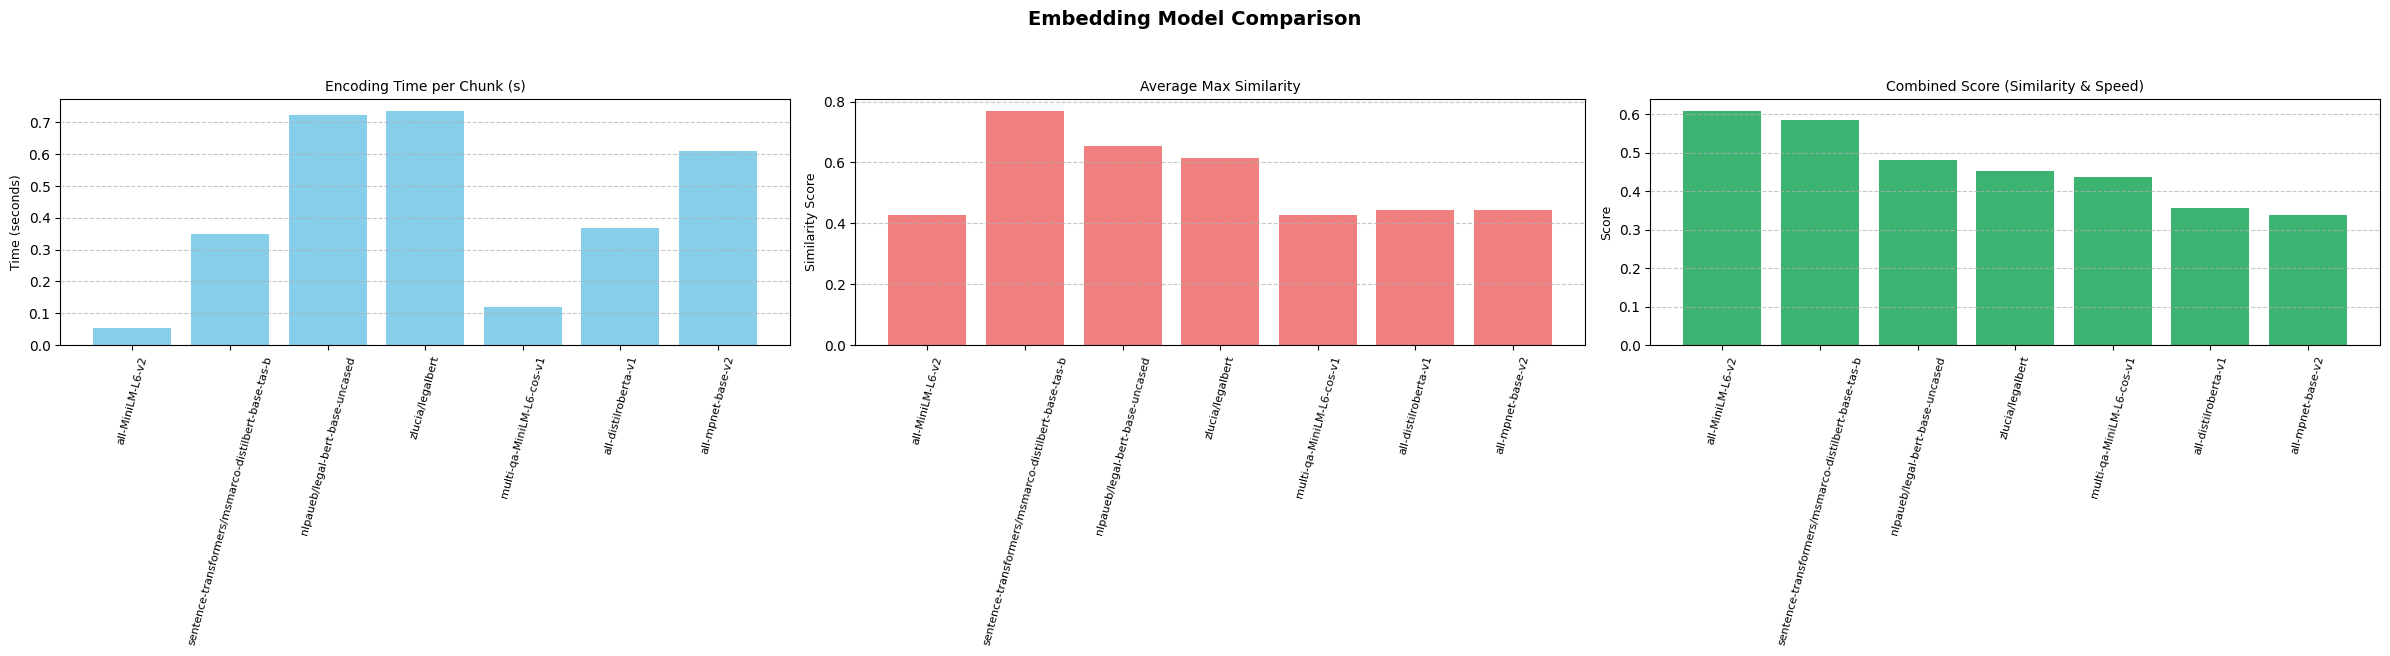


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Generated embeddings with shape: (6434, 384)

Finished generating embeddings. Shape of matrix: (6434, 384)
`hybrid_chunks_df` DataFrame now contains the 'embedding' column.
`full_embeddings_matrix` holds the numpy array of embeddings.
`final_model_object` is the loaded SentenceTransformer model.


In [19]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import time
import gc
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Global query embedding cache
query_embedding_cache = {}

def get_cached_query_embedding(query, model):
    global query_embedding_cache
    
    # Attempt to get a consistent model name for caching
    model_name_for_cache = getattr(model, 'name_or_path', None) # For HuggingFace models
    if model_name_for_cache is None:
        model_name_for_cache = getattr(model, 'model_name_or_path', str(model).split('(')[0]) # Fallback for SentenceTransformer
    
    cache_key = f"{model_name_for_cache}:{query}"
    
    if cache_key in query_embedding_cache:
        return query_embedding_cache[cache_key]
    
    try:
        query_embedding = model.encode([query], show_progress_bar=False)[0].astype(np.float32)
        # Normalize the embedding
        norm = np.linalg.norm(query_embedding)
        if norm == 0: # Avoid division by zero for zero vectors
            query_embedding_normalized = query_embedding
        else:
            query_embedding_normalized = query_embedding / norm
        
        query_embedding_cache[cache_key] = query_embedding_normalized
        
        # Limit cache size
        if len(query_embedding_cache) > 1000:
            oldest_query = next(iter(query_embedding_cache))
            query_embedding_cache.pop(oldest_query)
            
        return query_embedding_normalized
    except Exception as e:
        print(f"Error encoding query '{query}': {e}")
        # Return zero vector of appropriate dimension if model has get_sentence_embedding_dimension
        if hasattr(model, 'get_sentence_embedding_dimension'):
            return np.zeros(model.get_sentence_embedding_dimension(), dtype=np.float32)
        else: # Fallback if dimension cannot be determined (less ideal)
            return np.array([], dtype=np.float32) 

def compare_embedding_models(test_chunks_df, models_to_test_list):
    sample_docs_text = test_chunks_df.sample(min(5, len(test_chunks_df)))['text'].tolist()
    
    test_queries = []
    for doc_text_item in sample_docs_text:
        sentences = doc_text_item.split('.')
        if len(sentences) > 2:
            middle_sentence = sentences[len(sentences)//2].strip()
            if middle_sentence: test_queries.append(middle_sentence)
    
    if len(test_queries) < 3:
        fallback_queries = [
            "intellectual property rights of employees",
            "confidentiality obligations in agreements",
            "reporting workplace safety incidents"
        ]
        needed = 3 - len(test_queries)
        test_queries.extend(fallback_queries[:needed])
    
    sample_chunks_for_comparison = test_chunks_df.sample(min(100, len(test_chunks_df)))
    results = []
    all_normalized_speeds = []

    print("Pre-checking model encoding speeds...")
    for model_name in tqdm(models_to_test_list, desc="Pre-checking models"):
        try:
            model_temp = SentenceTransformer(model_name)
            chunk_texts_temp = sample_chunks_for_comparison['text'].tolist()
            start_time_temp = time.time()
            _ = model_temp.encode(chunk_texts_temp, show_progress_bar=False)
            encoding_time_temp = time.time() - start_time_temp
            normalized_speed_temp = 1.0 / (encoding_time_temp + 1e-9) # Add small epsilon
            all_normalized_speeds.append(normalized_speed_temp)
        except Exception as e:
            print(f"Error during pre-check for {model_name}: {e}")
            all_normalized_speeds.append(1e-9) # Assign very low speed
        finally:
            if 'model_temp' in locals(): del model_temp
            gc.collect()
            if torch.cuda.is_available(): torch.cuda.empty_cache()

    max_overall_normalized_speed = max(all_normalized_speeds) if all_normalized_speeds else 1.0
    if max_overall_normalized_speed == 0: max_overall_normalized_speed = 1.0 # Avoid division by zero

    print("\nTesting embedding models...")
    for model_name in tqdm(models_to_test_list, desc="Testing embedding models"):
        try:
            start_time = time.time()
            model = SentenceTransformer(model_name)
            load_time = time.time() - start_time
            
            chunk_texts_for_eval = sample_chunks_for_comparison['text'].tolist()
            start_time_encoding = time.time()
            chunk_embeddings = model.encode(chunk_texts_for_eval, show_progress_bar=False)
            encoding_time = time.time() - start_time_encoding
            
            query_embeddings = model.encode(test_queries, show_progress_bar=False)
            
            avg_similarity = 0.0
            if query_embeddings.shape[0] > 0 and chunk_embeddings.shape[0] > 0:
                for query_emb in query_embeddings:
                    sims = cosine_similarity(query_emb.reshape(1, -1), chunk_embeddings)[0]
                    avg_similarity += np.max(sims) if len(sims) > 0 else 0.0
                avg_similarity /= query_embeddings.shape[0]
            
            normalized_similarity = avg_similarity
            current_normalized_speed = 1.0 / (encoding_time + 1e-9)
            scaled_speed_score = current_normalized_speed / max_overall_normalized_speed
            
            combined_score = (0.7 * normalized_similarity) + (0.3 * scaled_speed_score)
            embedding_dim_val = model.get_sentence_embedding_dimension() if hasattr(model, 'get_sentence_embedding_dimension') else None
            if embedding_dim_val is None and chunk_embeddings.ndim > 1 : embedding_dim_val = chunk_embeddings.shape[1]

            results.append({
                'model_name': model_name, 'embedding_dim': embedding_dim_val,
                'load_time': load_time, 'encoding_time': encoding_time,
                'avg_max_similarity': avg_similarity,
                'encoding_time_per_doc': encoding_time / len(chunk_texts_for_eval) if len(chunk_texts_for_eval) > 0 else float('inf'),
                'combined_score': combined_score
            })
        except Exception as e:
            print(f"Error testing model {model_name}: {e}")
            results.append({
                'model_name': model_name, 'embedding_dim': None, 'load_time': None, 
                'encoding_time': None, 'avg_max_similarity': None, 
                'encoding_time_per_doc': None, 'combined_score': None, 'error': str(e)
            })
        finally:
            if 'model' in locals(): del model
            gc.collect()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
                
    return pd.DataFrame(results)

def generate_optimized_embeddings(source_chunks_df, model_name_to_use):
    print(f"Loading model: {model_name_to_use}")
    model = SentenceTransformer(model_name_to_use)
    
    batch_size = 32
    if torch.cuda.is_available():
        try:
            free_mem_bytes = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
            free_mem_gb = free_mem_bytes / (1024**3)
            if free_mem_gb > 12: batch_size = 128
            elif free_mem_gb > 8: batch_size = 64
            elif free_mem_gb > 4: batch_size = 32
            else: batch_size = 16
            print(f"CUDA available ({free_mem_gb:.2f}GB free). Using batch size: {batch_size}")
        except Exception as e:
            print(f"Could not query CUDA memory, defaulting batch size to 32. Error: {e}")
            batch_size = 32
    else:
        print(f"CUDA not available. Using CPU batch size: {batch_size}")
    
    print("Generating embeddings...")
    texts_to_embed = source_chunks_df['text'].tolist()
    num_texts = len(texts_to_embed)
    embedding_dim = model.get_sentence_embedding_dimension()
    all_embeddings = np.zeros((num_texts, embedding_dim), dtype=np.float32)
    
    if num_texts > 0:
        for i in tqdm(range(0, num_texts, batch_size), desc="Batch encoding"):
            batch_texts = texts_to_embed[i:i+batch_size]
            batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True).astype(np.float32)
            all_embeddings[i:i+len(batch_texts)] = batch_embeddings
    
    output_chunks_df = source_chunks_df.copy() # Make a copy to avoid SettingWithCopyWarning
    output_chunks_df['embedding'] = list(all_embeddings)
    
    print(f"Generated embeddings with shape: {all_embeddings.shape}")
    return output_chunks_df, all_embeddings, model

# --- Main script execution for embedding generation ---

# Ensure `hybrid_chunks_df` is available from your previous chunking step.
if 'hybrid_chunks_df' in locals() and hybrid_chunks_df is not None and not hybrid_chunks_df.empty:
    print(f"Proceeding with embedding generation for {len(hybrid_chunks_df)} chunks.")
    
    models_to_test_list = [
        'all-MiniLM-L6-v2',           # Fast, good baseline
        'multi-qa-MiniLM-L6-cos-v1',  # Optimized for semantic search (QA)
        'sentence-transformers/msmarco-distilbert-base-tas-b', # TAS-B for dense retrieval
        'nlpaueb/legal-bert-base-uncased', # Legal-specific BERT
        'zlucia/legalbert',                # Another legal-specific BERT, often performs well
        'all-mpnet-base-v2',           # High quality, but slower
        'all-distilroberta-v1',        # Good balance
    ]
    
    sample_size_for_comparison = min(500, len(hybrid_chunks_df))
    test_chunks_for_model_comparison = hybrid_chunks_df.sample(sample_size_for_comparison, random_state=42)
    
    print(f"\nComparing {len(models_to_test_list)} models using a sample of {len(test_chunks_for_model_comparison)} chunks...")
    model_comparison_df = compare_embedding_models(test_chunks_for_model_comparison, models_to_test_list)
    
    print("\nModel Comparison Results:")
    try:
        display(model_comparison_df.sort_values(by='combined_score', ascending=False))
    except NameError: # Fallback if not in Jupyter
        print(model_comparison_df.sort_values(by='combined_score', ascending=False).to_string())

    if not model_comparison_df.empty and 'model_name' in model_comparison_df.columns:
        plot_df = model_comparison_df.dropna(subset=['encoding_time_per_doc', 'avg_max_similarity', 'combined_score']).copy()
        if not plot_df.empty:
            plot_df.sort_values(by='combined_score', ascending=False, inplace=True)
            fig, ax = plt.subplots(1, 3, figsize=(24, 7))
            
            ax[0].bar(plot_df['model_name'], plot_df['encoding_time_per_doc'], color='skyblue')
            ax[0].set_title('Encoding Time per Chunk (s)', fontsize=10)
            ax[0].set_ylabel('Time (seconds)', fontsize=9)
            ax[0].tick_params(axis='x', rotation=75, labelsize=8)
            ax[0].grid(axis='y', linestyle='--', alpha=0.7)

            ax[1].bar(plot_df['model_name'], plot_df['avg_max_similarity'], color='lightcoral')
            ax[1].set_title('Average Max Similarity', fontsize=10)
            ax[1].set_ylabel('Similarity Score', fontsize=9)
            ax[1].tick_params(axis='x', rotation=75, labelsize=8)
            ax[1].grid(axis='y', linestyle='--', alpha=0.7)

            ax[2].bar(plot_df['model_name'], plot_df['combined_score'], color='mediumseagreen')
            ax[2].set_title('Combined Score (Similarity & Speed)', fontsize=10)
            ax[2].set_ylabel('Score', fontsize=9)
            ax[2].tick_params(axis='x', rotation=75, labelsize=8)
            ax[2].grid(axis='y', linestyle='--', alpha=0.7)
            
            plt.suptitle('Embedding Model Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout(rect=[0, 0.05, 1, 0.95])
            plt.show()
        else:
            print("No valid model data to plot after filtering errors.")
            
        if 'combined_score' in model_comparison_df.columns and not model_comparison_df['combined_score'].isnull().all():
            best_model_row = model_comparison_df.loc[model_comparison_df['combined_score'].idxmax()]
            selected_model_name = best_model_row['model_name']
            print(f"\nSelected best model: {selected_model_name} (Score: {best_model_row['combined_score']:.4f})")
            
            print(f"\nGenerating final embeddings for all {len(hybrid_chunks_df)} chunks using {selected_model_name}...")
            # The generate_optimized_embeddings function returns the df with embeddings, the matrix, and the model
            hybrid_chunks_df, full_embeddings_matrix, final_model_object = generate_optimized_embeddings(hybrid_chunks_df, selected_model_name)
            
            print(f"\nFinished generating embeddings. Shape of matrix: {full_embeddings_matrix.shape}")
            print("`hybrid_chunks_df` DataFrame now contains the 'embedding' column.")
            print("`full_embeddings_matrix` holds the numpy array of embeddings.")
            print("`final_model_object` is the loaded SentenceTransformer model.")
            
            # Optional: Save the DataFrame with embeddings
# hybrid_chunks_df.to_pickle("hybrid_chunks_with_embeddings.pkl")
# print("Saved hybrid_chunks_df to hybrid_chunks_with_embeddings.pkl")
        else:
            print("\nCould not select the best model. Check comparison results for errors or all NaN scores.")
    else:
        print("\nModel comparison DataFrame is empty or malformed. Skipping plotting and final embedding generation.")
else:
    print("hybrid_chunks_df is not defined or is empty. Please ensure the chunking step has run successfully and `hybrid_chunks_df` is populated.")

In [20]:
# Save hybrid_chunks_df (Pandas DataFrame with embeddings)
print("Attempting to save hybrid_chunks_df...")
try:
    if 'hybrid_chunks_df' in locals() or 'hybrid_chunks_df' in globals():
        hybrid_chunks_df.to_pickle('c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl')
        print("DataFrame 'hybrid_chunks_df' saved to 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'")
    else:
        print("Error: 'hybrid_chunks_df' not defined. Please ensure the previous cells that create this DataFrame have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving hybrid_chunks_df: {e}")

Attempting to save hybrid_chunks_df...
DataFrame 'hybrid_chunks_df' saved to 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'


In [21]:
# Save full_embeddings_matrix (NumPy array)
import numpy as np
print("Attempting to save full_embeddings_matrix...")
try:
    if 'full_embeddings_matrix' in locals() or 'full_embeddings_matrix' in globals():
        np.save('c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy', full_embeddings_matrix)
        print("NumPy array 'full_embeddings_matrix' saved to 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'")
    else:
        print("Error: 'full_embeddings_matrix' not defined. Please ensure the previous cells that create this NumPy array have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving full_embeddings_matrix: {e}")

Attempting to save full_embeddings_matrix...
NumPy array 'full_embeddings_matrix' saved to 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'
